# Mean analysis for HBECs

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm
pd.set_option('display.max_rows', 600)

In [2]:
import functools

In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq')
import encode
import memento

In [4]:
data_path = '/data_volume/memento/hbec/'
# fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig6/'

In [5]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Read 1D HT results

In [7]:
cts = ['C', 'B', 'BC', 'all_ct']
tps = [ '3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [8]:
def read_result():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_latest/C_{}_3.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        moments_dict[stim] = memento.get_1d_moments(adata_subset, groupby='time_step')
    return ht_dict,moments_dict

In [9]:
ht, moments = read_result()

In [10]:
tp = '6'
ct = 'all_ct'
for idx, stim in enumerate(stims):
    
    if idx == 0:
        df = ht[stim][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
    else:
        a = ht[stim][['gene', 'de_coef', 'de_pval', 'de_fdr']].rename(columns=dict(zip(['de_coef', 'de_pval', 'de_fdr'], ['logfc_'+stim, 'pv_'+stim, 'fdr_'+stim])))
        df = df.merge(a, on='gene', how='outer')

### Graph ISG comparisons for each stim

In [11]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import statsmodels.formula.api as smf
import statsmodels.api as sm

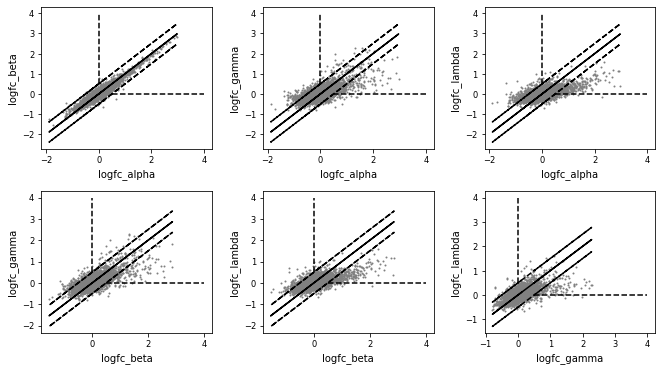

In [12]:
plt.figure(figsize=(11, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)
    subset = subset[(subset.max(axis=1) < 1000)&(subset.min(axis=1) > -1000)]

    x, y = subset[c[0]], subset[c[1]]

    plt.subplot(2, 3, idx+1)
    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k')
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k')
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k')
    plt.plot([0, 0], [0.5, 4], '--', color='k')
    plt.plot([0.5, 4], [0, 0], '--', color='k')
    
    
#     plt.plot([0, 0.5, 0.5], [0.5, 0.5, 0], '--', color='k')

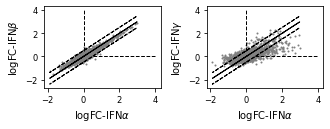

In [13]:
plt.figure(figsize=(5, 1.5))
plt.subplots_adjust(wspace=0.4)
cols = ['logfc_alpha','logfc_beta', 'logfc_gamma', 'logfc_lambda']
for idx, c in enumerate(itertools.combinations(cols,2)):
    
    subset = df[[c[0], c[1]]].copy()
    subset.dropna(inplace=True)
    subset = subset[(subset.max(axis=1) < 1000)&(subset.min(axis=1) > -1000)]

    x, y = subset[c[0]], subset[c[1]]

    plt.subplot(1, 2, idx+1);

    plt.scatter(x, y, s=1, color='grey');
    plt.xlabel(c[0]); plt.ylabel(c[1])
    # plt.plot([-1.5, 3], [-1.5, 3])
    xs = np.arange(0, x.max())
    plt.plot(x,x+0.5, '--', color='k', lw=1)
    xs = np.arange(0.5, x.max())
    plt.plot(x,x, color='k', lw=1)
    xs = np.arange(0, x.max()+0.5)
    plt.plot(x,x-0.5, '--', color='k', lw=1)
    plt.plot([0, 0], [0.5, 4], '--', color='k', lw=1)
    plt.plot([0.5, 4], [0, 0], '--', color='k', lw=1)
    plt.xlabel(r'logFC-IFN$\alpha$')

    if idx == 0:
        plt.ylabel(r'logFC-IFN$\beta$')
    if idx == 1:
        plt.ylabel(r'logFC-IFN$\gamma$')
        break
plt.savefig('stim_lfc_scatter.png', bbox_inches='tight', dpi=500)

### Create long/wide form of HT results

In [14]:
# Create longform data

longform = []
    
for stim in stims:

    a = ht[stim]
    a['stim'] = stim
    a['lfc'] = a['de_coef']
    a['fdr'] = a['de_fdr']
    longform.append(a[['gene', 'lfc', 'stim', 'fdr']].copy())

longform = pd.concat(longform)


In [15]:
wideform = longform.pivot(index='gene', columns=['stim'], values=['lfc', 'fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_fdr = longform.pivot(index='gene', columns=['stim'], values=['fdr'])#.loc[:, 'C'].loc[:, ['control', '']
wideform_hr = wideform

### Define type specific/shared ISGs

In [16]:
# isg_types = ['type1', 'type2','shared']
# tps = [3, 6, 9, 24, 48]
# tps=[6]
# isg_class_df = pd.DataFrame()
# wideform_hr = wideform
# for isg_type in isg_types:
#     if isg_type == 'type2': # gamma

#         type1_both = wideform_hr['lfc'][['alpha', 'beta']].max(axis=1)
#         rest = pd.concat([type1_both, wideform_hr['lfc']['lambda']], axis=1).max(axis=1)a
#         isg_class_df['is_type2'] = (wideform_hr['lfc']['gamma'] > 0.5) & (rest < 0.25) & (wideform_hr['fdr']['gamma'] < 0.05) 

#     if isg_type == 'type1':

#         type1_both = wideform_hr['lfc'][['alpha', 'beta']].max(axis=1)
#         rest = pd.concat([wideform_hr['lfc']['gamma'], wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
#         isg_class_df['is_type1'] = (type1_both > 0.5) & (rest < 0.25) & ((wideform_hr['fdr']['beta'] < 0.05) | (wideform_hr['fdr']['alpha'] < 0.05))

#     if isg_type == 'shared':

#         isg_class_df['is_shared'] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].min(axis=1) > 0.5) & (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].max(axis=1) - wideform_hr['lfc'][['alpha', 'beta', 'gamma']].min(axis=1) < 0.01) & (wideform_hr['fdr'][['alpha', 'beta', 'gamma']].max(axis=1) < 0.05)
#         isg_class_df['is_shared'] = isg_class_df['is_shared'] & ~isg_class_df['is_type1'] & ~isg_class_df['is_type2']
        
# isg_class_df = isg_class_df[isg_class_df.sum(axis=1) > 0].copy()


In [17]:
isg_types = ['type1', 'type2', 'type3','shared']
tps = [3, 6, 9, 24, 48]
tps=[6]
isg_class_df = pd.DataFrame()
wideform_hr = wideform
for isg_type in isg_types:
    if isg_type == 'type2': # gamma

        type1_both = wideform_hr['lfc'][['alpha', 'beta']].min(axis=1)
        rest = pd.concat([type1_both, wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
        isg_class_df['is_type2'] = (wideform_hr['lfc']['gamma'] > 0.5) & (rest < 0.25) & (wideform_hr['fdr']['gamma'] < 0.05) 

    if isg_type == 'type1':

        type1_both = wideform_hr['lfc'][['alpha', 'beta']].max(axis=1)
        rest = pd.concat([wideform_hr['lfc']['gamma'], wideform_hr['lfc']['lambda']], axis=1).max(axis=1)
        isg_class_df['is_type1'] = (type1_both > 0.5) & (rest < 0.25) & ((wideform_hr['fdr']['beta'] < 0.05) | (wideform_hr['fdr']['alpha'] < 0.05))

    if isg_type == 'shared':

        isg_class_df['is_shared'] = (wideform_hr['lfc'][['alpha', 'beta', 'gamma']].min(axis=1) > 0.25) & (wideform_hr['fdr'][['alpha', 'beta', 'gamma']].max(axis=1) < 0.05)
        isg_class_df['is_shared'] = isg_class_df['is_shared'] & ~isg_class_df['is_type1'] & ~isg_class_df['is_type2'] #& ~isg_class_df['is_type3']
        
isg_class_df = isg_class_df[isg_class_df.sum(axis=1) > 0].copy()

### Consolidate an ISG class for each gene

In [18]:
def classify(row):
    
    if row['is_type1']: return 'type1'
    elif row['is_type2']: return 'type2'
    else: return 'shared'
    
    

In [19]:
isg_class_df['overall_type'] = isg_class_df.apply(classify, axis=1)
isg_class_df.to_csv('../isg_classes2.csv')

In [20]:
isg_class_df.shape

(762, 4)

In [21]:
isg_class_df.overall_type.value_counts()

shared    577
type1     157
type2      28
Name: overall_type, dtype: int64

### Read ISG classes

In [22]:
isg_classes = pd.read_csv('../isg_classes2.csv')
t1_isg = isg_classes.query('overall_type =="type1"').gene.tolist()
t2_isg = isg_classes.query('overall_type =="type2"').gene.tolist()
shared_isg = isg_classes.query('overall_type == "shared"').gene.tolist()
all_isg = isg_classes[isg_classes.sum(axis=1) > 0].gene.tolist()

In [23]:
len(all_isg)

762

### DE gene heatmap

In [24]:
tps = ['3', '6', '9', '24', '48']

In [25]:
ct = 'C'
all_tp_ht = []
for tp in tps:
    ht = [
        memento.get_1d_ht_result(
            sc.read(data_path + 'binary_test_latest/{}_{}_{}.h5ad'.format(ct, stim, tp)))\
            .rename(columns={'de_coef':'lfc_{}_{}'.format(stim, tp)})[['gene', 'lfc_{}_{}'.format(stim,tp)]] \
        for stim in stims]
    lfc = functools.reduce( lambda x,y: x.merge(y, on='gene'), ht,).query('gene in @all_isg')
    all_tp_ht.append(lfc)

In [26]:
all_tp_ht = functools.reduce( lambda x,y: x.merge(y, on='gene'), all_tp_ht)

In [32]:
# Cluster each gene type separately
ordered_heatmaps = []
for gene_set in [t1_isg, t2_isg, shared_isg]:
    a = all_tp_ht.query('gene in @gene_set')#.iloc[:, 1:]
    cg = sns.clustermap(a.iloc[:, 1:], vmax=0.7, row_cluster=True, col_cluster=True, cmap='coolwarm', center=0, figsize=(4,2))
    row_order = cg.dendrogram_row.reordered_ind
    plt.close()
    
#     customize
    if gene_set == t1_isg:
        row_order = row_order[::-1]
    if gene_set == shared_isg:
        row_order = row_order[300:]
        print(len(row_order))
    if gene_set == t2_isg:
        row_order = row_order[::-1]
    ordered_heatmaps.append(a.iloc[row_order,:].copy())
final_heatmap = pd.concat(ordered_heatmaps, axis=0, ignore_index=True)
final_heatmap.index = final_heatmap['gene']
final_heatmap.drop('gene', axis=1, inplace=True)

94


In [36]:
final_heatmap.index.tolist().index('CXCL10')

190

In [45]:
t1_isg

['AC007996.1',
 'AC008875.3',
 'AC010168.2',
 'AC025539.1',
 'AC234582.1',
 'ADAM17',
 'ADRB2',
 'AIFM2',
 'AKAP7',
 'AKNA',
 'AL603756.1',
 'ANKRD45',
 'AP1B1',
 'AP5B1',
 'ARAP1',
 'ARAP2',
 'ARFGAP1',
 'ARNTL2',
 'ATF5',
 'ATP13A1',
 'ATP6V0A1',
 'BCL2L13',
 'BLZF1',
 'BMPR1A',
 'BRCA2',
 'C16orf70',
 'C1GALT1',
 'C2orf92',
 'CARD8',
 'CCDC71L',
 'CCND3',
 'CCNL1',
 'CD47',
 'CD68',
 'CDK17',
 'CHRNB1',
 'CKAP2',
 'CMTR1',
 'COLGALT1',
 'CWF19L1',
 'DAB2IP',
 'DCLRE1C',
 'DCP1A',
 'DLG5',
 'DOP1A',
 'EBF4',
 'EHD1',
 'ERBB4',
 'EXT1',
 'FAM126B',
 'FRYL',
 'GGT6',
 'GPAT4',
 'GPR180',
 'GSDMB',
 'H1F0',
 'HES4',
 'HIST1H1C',
 'HIST1H1D',
 'HIST1H2AC',
 'HIST1H2BC',
 'HIST1H2BD',
 'HIST1H2BJ',
 'HIST2H2AA4',
 'HIST3H2A',
 'HIVEP2',
 'HRK',
 'IGFBP4',
 'IKBKE',
 'INPP5D',
 'IRAK1',
 'ITPR3',
 'JADE2',
 'KDM2A',
 'KIAA0513',
 'KRT23',
 'LAYN',
 'LEMD2',
 'LINC00865',
 'LNPEP',
 'LPIN2',
 'LRRC8A',
 'LYN',
 'LZTS2',
 'MYO9B',
 'N4BP1',
 'NAIP',
 'NINJ1',
 'NLRX1',
 'NPLOC4',
 'OSBPL5',


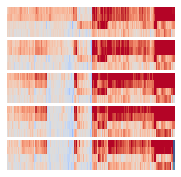

In [37]:
plt.figure(figsize=(3, 3))
plt.subplots_adjust(hspace=0.1)
for idx, tp in enumerate(tps):
    plt.subplot(5, 1,  idx+1)
    zscore = final_heatmap[['lfc_{}_{}'.format(stim, tp) for stim in stims]]
#     zscore = (zscore - zscore.mean(axis=0))/zscore.std(axis=0)
    sns.heatmap(zscore.T, vmax=1.7,cmap='coolwarm', center=0, xticklabels=False, yticklabels=False, cbar=False)
    plt.xlabel(None); plt.ylabel(None)
plt.plot([190,190], [0, 10])
# plt.savefig('de_heatmap_all_tp.png', dpi=1000, bbox_inches='tight')

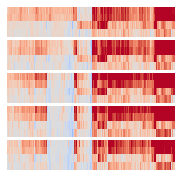

In [34]:
plt.figure(figsize=(3, 3))
plt.subplots_adjust(hspace=0.1)
for idx, tp in enumerate(tps):
    plt.subplot(5, 1,  idx+1)
    zscore = final_heatmap[['lfc_{}_{}'.format(stim, tp) for stim in stims]]
#     zscore = (zscore - zscore.mean(axis=0))/zscore.std(axis=0)
    sns.heatmap(zscore.T, vmax=1.7,cmap='coolwarm', center=0, xticklabels=False, yticklabels=False, cbar=False)
    plt.xlabel(None); plt.ylabel(None)
plt.savefig('de_heatmap_all_tp.png', dpi=1000, bbox_inches='tight')

### Dynamic ISGs

In [580]:
adata = sc.read(data_path + 'HBEC_type_I_filtered_processed_deep.h5ad')

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/data_volume/memento/hbec/HBEC_type_I_filtered_processed_deep.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [31]:
def read_result_dynamic():
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        adata_subset = sc.read(data_path + '/binary_test_stratified/{}_stratified_time.h5ad'.format(stim))
        ht_dict[stim] = memento.get_1d_ht_result(adata_subset)
        ht_dict[stim]['de_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['de_pval'])
        ht_dict[stim]['dv_fdr'] = memento.util._fdrcorrect(ht_dict[stim]['dv_pval'])
        m, v = memento.get_1d_moments(adata_subset, groupby='time_step')
        m = m[['gene'] + ['time_step_'+str(i) for i in range(5)]]
        v =v[['gene'] + ['time_step_'+str(i) for i in range(5)]]
        moments_dict[stim] = (m,v)
    return ht_dict,moments_dict

In [32]:
ht, moments = read_result_dynamic()

In [92]:
dynamic_up_genes = ['HERC5', 'CXCL10', 'GPR155']
dynamic_up_genes=['GPR155']
dynamic_down_genes = ['HLA-A', 'IFI6']
mean_plot_genes = ['CXCL10', 'HLA-A', 'MX2', 'HERC5', 'IFI6', 'IFI35']

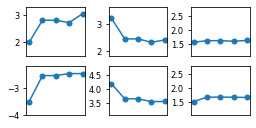

In [93]:
plt.figure(figsize=(4,2))
plt.subplots_adjust(wspace=0.4)
for idx, g in enumerate(mean_plot_genes):
    plt.subplot(2, 3, idx+1)
    data = moments['beta'][0].query('gene =="{}"'.format(g)).iloc[:, 1:].T.values
    plt.plot(data, '-o', markersize=5)
    plt.ylim(data.min()-0.5, data.min()-0.5+1.8)
    plt.xlabel(None)
    plt.xticks([])
plt.savefig('dynamic_isg_mean.pdf', bbox_inches='tight')

In [46]:
gene = 'HERC5'
print(moments['beta'][0].query('gene == "{}"'.format(gene)))
print(moments['beta'][1].query('gene == "{}"'.format(gene)))

       gene  time_step_0  time_step_1  time_step_2  time_step_3  time_step_4
2300  HERC5     0.611819      1.17295      1.17295     1.265678      1.22302
       gene  time_step_0  time_step_1  time_step_2  time_step_3  time_step_4
2300  HERC5     0.581841     0.320634     0.320634     0.312659      0.27194


In [63]:
ht['beta']['es'] = ht['beta']['de_coef'].abs()

In [90]:
ht['beta'].query('gene in @t1_isg').sort_values('es').head(5)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr,es
5591,STAT2,0.000147,0.005535,0.976302,0.013977,0.038747,0.704230,0.978872,0.917334,0.000147
633,ADAR,-0.001423,0.004616,0.754125,0.018198,0.049401,0.689231,0.783696,0.912488,0.001423
6188,PLEKHH1,-0.002823,0.014430,0.850515,0.057379,0.066023,0.404760,0.869536,0.783055,0.002823
8171,NAPA,0.003214,0.006115,0.601540,-0.026803,0.065813,0.664334,0.645601,0.903197,0.003214
3104,CCND3,0.004962,0.007539,0.508149,-0.048072,0.064083,0.441156,0.556541,0.803528,0.004962


In [ ]:
ht['beta'].query('de_fdr < 0.05 & gene in @all_isg')#.sort_values('de_coef', ascending=True)

In [91]:
ht['beta'].query('de_fdr < 0.05 & gene in @all_isg').sort_values('de_coef', ascending=True).head(5)

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,de_fdr,dv_fdr,es
3000,HCP5,-0.512881,0.022473,0.000001,-0.003346,0.069033,0.963004,0.000145,0.990855,0.512881
1926,TF,-0.430389,0.020898,0.000002,-0.170243,0.041518,0.000670,0.000187,0.019820,0.430389
180,IFI6,-0.386419,0.002723,0.000005,-0.082398,0.020131,0.001010,0.000261,0.027075,0.386419
6276,IFI27,-0.363440,0.003580,0.000011,0.228381,0.015901,0.000069,0.000356,0.006492,0.363440
2975,HLA-A,-0.360574,0.003714,0.000008,0.084324,0.024969,0.001800,0.000323,0.038004,0.360574
